**1. Imports**

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import joblib

**2. Load Required Data**

In [2]:
orders = pd.read_csv("../data/raw/orders.csv")
op_train = pd.read_csv("../data/raw/order_products__train.csv")

user = pd.read_parquet("../data/features/user_features.parquet")
prod = pd.read_parquet("../data/features/product_features.parquet")
up = pd.read_parquet("../data/features/user_product_features.parquet")

prior = pd.read_parquet("../data/features/prior_merged.parquet")


**3. Build Training Candidates**

*3.1 Identify training orders*

In [3]:
orders_train = orders[orders["eval_set"] == "train"][["order_id", "user_id"]]

*3.2 Candidate pairs (user x product they have bought before)*

In [ ]:
# up_pairs = up[["user_id", "product_id"]]
# train_candidates = orders_train.merge(up_pairs, on="user_id", how="left")

**4. Attach Labels**

In [ ]:
# op_train["label"] = 1
# labels = op_train[["order_id", "product_id", "label"]]

# train_candidates = train_candidates.merge(labels, on=["order_id", "product_id"], how="left")
# train_candidates["label"] = train_candidates["label"].fillna(0)

**5. Join Features**

In [16]:
# Before merging, enforce expected uniqueness
assert user["user_id"].is_unique, "user_features must be 1 row per user_id"
assert prod["product_id"].is_unique, "product_features must be 1 row per product_id"
assert up.set_index(["user_id", "product_id"]).index.is_unique, (
    "up must be 1 row per (user_id, product_id)"
)

# Safer candidate base (avoid accidental duplicates)
up_pairs = up[["user_id", "product_id"]].drop_duplicates()
train_candidates = orders_train.merge(
    up_pairs, on="user_id", how="left", validate="1:m"
)

# Labels merge should be many-to-one
labels = op_train.assign(label=1)[["order_id", "product_id", "label"]]
train_candidates = train_candidates.merge(
    labels, on=["order_id", "product_id"], how="left", validate="m:1"
)
train_candidates["label"] = train_candidates["label"].fillna(0).astype("int8")

# Feature merges must be many-to-one
X = (
    train_candidates.merge(user, on="user_id", how="left", validate="m:1")
    .merge(prod, on="product_id", how="left", validate="m:1")
    .merge(up, on=["user_id", "product_id"], how="left", validate="m:1")
)


In [17]:
# X = (train_candidates
#      .merge(user, on="user_id", how="left")
#      .merge(prod, on="product_id", how="left")
#      .merge(up, on=["user_id", "product_id"], how="left")
# )

y = X["label"]

*Drop identifiers:*

In [18]:
# drop_cols = ["order_id", "user_id", "product_id", "label", "product_name"]
# X_model = X.drop(columns=drop_cols)
drop_cols = ["order_id", "user_id", "product_id", "label", "product_name", "index"]
X_model = X.drop(columns=[c for c in drop_cols if c in X.columns])


**6. Split Data**

*Split by order_id to avoid leakage:*

In [19]:
train_orders, val_orders = train_test_split(
    orders_train["order_id"].unique(), test_size=0.2, random_state=42
)

mask = X["order_id"].isin(train_orders)
X_train, y_train = X_model[mask], y[mask]
X_val, y_val = X_model[~mask], y[~mask]

**7. Train LightGBM Model**

In [20]:
from lightgbm import early_stopping, log_evaluation

train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

model = lgb.train(
    params=params,
    train_set=train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=2000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50),
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.25332	valid_1's binary_logloss: 0.252714
[100]	training's binary_logloss: 0.248608	valid_1's binary_logloss: 0.24819
[150]	training's binary_logloss: 0.247444	valid_1's binary_logloss: 0.247282
[200]	training's binary_logloss: 0.246808	valid_1's binary_logloss: 0.246938
[250]	training's binary_logloss: 0.246332	valid_1's binary_logloss: 0.24679
[300]	training's binary_logloss: 0.245935	valid_1's binary_logloss: 0.246703
[350]	training's binary_logloss: 0.24558	valid_1's binary_logloss: 0.246662
[400]	training's binary_logloss: 0.245282	valid_1's binary_logloss: 0.246644
[450]	training's binary_logloss: 0.244974	valid_1's binary_logloss: 0.246612
[500]	training's binary_logloss: 0.24465	valid_1's binary_logloss: 0.24659
[550]	training's binary_logloss: 0.244358	valid_1's binary_logloss: 0.24656
[600]	training's binary_logloss: 0.244091	valid_1's binary_logloss: 0.246546
[650]	training's binary

**8. Save Model**

In [21]:
# model.save_model("../models/lightgbm_reorder.txt")
joblib.dump(model, "../models/lightgbm_reorder.joblib")

['../models/lightgbm_reorder.joblib']

**9. Quick Feature Importance Visualization**

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

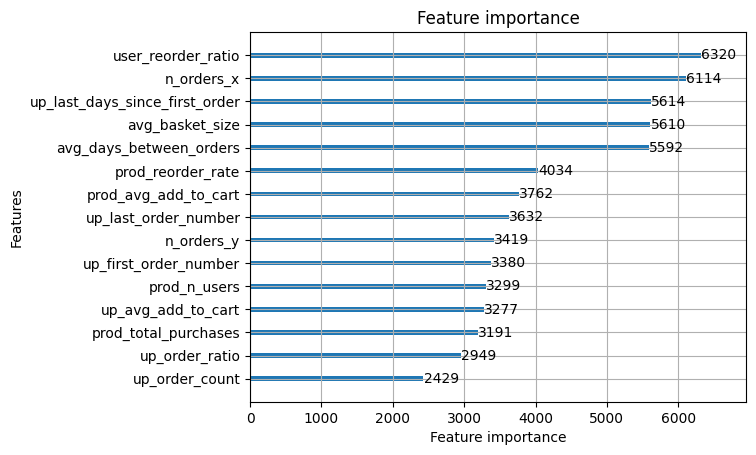

In [22]:
lgb.plot_importance(model, max_num_features=20)